# How Binomial is Skeet Shooting?

Based on Chapter 5 of Think Stats

In [33]:
import os
import urllib.request
import urllib.parse

def download(url):
    filename = os.path.basename(urllib.parse.unquote(url))
    if not os.path.exists(filename):
        urllib.request.urlretrieve(url, filename)
        print("Downloaded " + filename)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## The Binomial Distribution

In the sport of skeet shooting, competitors use shotguns to shoot clay disks that are thrown into the air.
In international competition, including the Olympics, there are five rounds with 25 targets per round, with additional rounds as needed to determine a winner.

As a model of a skeet-shooting competition, suppose that every participant has the same probability of hitting every target, `p`.
Of course, this model is a simplification -- in reality, it's likely that some competitors have a higher probability than others, and even for a single competitor, it might vary from one attempt to the next.
But even if it is not realistic, this model make some surprisingly accurate predictions, as we'll see.

To simulate the model, I'll use the following function, which takes the number of targets, `n`, and the probability of hitting each one, `p`, and returns a sequence of 1s and 0s to indicate hits and misses.

In [4]:
def flip(n, p):
    choices = [1, 0]
    probs = [p, 1 - p]
    return np.random.choice(choices, n, p=probs)

Here's an example that simulates a round of 25 targets where the probability of hitting each one is 90%.

In [5]:
flip(25, 0.9)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1])

If we generate a sequence of 1000 attempts, and compute the `Pmf` of the results, we can confirm that the proportions of 1s and 0s are correct, at least approximately.

In [6]:
from empiricaldist import Pmf

seq = flip(1000, 0.9)
pmf = Pmf.from_seq(seq)
pmf

,probs
0,0.116
1,0.884


Now we can use `flip` to simulate a round of skeet shooting and return the number of hits.

In [7]:
def simulate_round(n, p):
    seq = flip(n, p)
    return seq.sum()

In a large competition, suppose 200 competitors shoot 5 rounds each, all with the same probability of hitting the target, `p=0.9`.
We can simulate a competition like that by calling `simulate_round` 1000 times.

In [8]:
n = 25
p = 0.9
results_sim = [simulate_round(n, p) for i in range(1000)]

The average score is close to `22.5`, which is the product of `n` and `p`.

In [9]:
np.mean(results_sim), n * p

(22.537, 22.5)

Here's what the distribution of the results looks like.

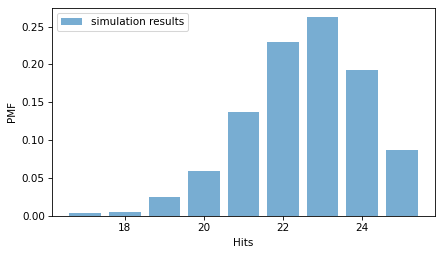

In [10]:
from empiricaldist import Pmf

pmf_sim = Pmf.from_seq(results_sim, name="simulation results")

pmf_sim.bar(alpha=0.6)
decorate(xlabel="Hits", ylabel="PMF")

Instead of running a simulation, we could have predicted this distribution.
Mathematically, we can show that the distribution of these outcomes follows a binomial distribution, which has a PMF that is easy to compute.

In [11]:
from scipy.special import comb


def binomial_pmf(k, n, p):
    """Compute the binomial PMF.

    k (int or array-like): number of successes
    n (int): number of trials
    p (float): probability of success on a single trial

    returns: float or ndarray
    """
    return comb(n, k) * (p**k) * ((1 - p) ** (n - k))

This function computes the probability of getting `k` hits out of `n` attempts, given `p`.
If we call this function with a range of `k` values, we can make a `Pmf` that represents the distribution of the outcomes.

In [12]:
ks = np.arange(16, n + 1)
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

And here's what it looks like compared to the simulation results.

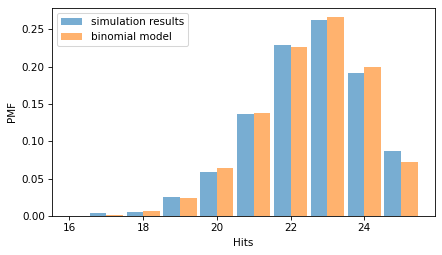

In [13]:
from thinkstats import two_bar_plots

two_bar_plots(pmf_sim, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

They are similar, with small differences because of random variation in the simulation results.

This agreement should not be surprising, because the simulation and the model are based on the same assumptions -- particularly the assumption that every attempt has the same probability of success.
The real test of a model is how it compares to real data.

From the Wikipedia page for the men's skeet shooting competition at the 2020 Summer Olympics, we can extract a table that shows the results for the qualification rounds of the competition.

Downloaded from <https://en.wikipedia.org/wiki/Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet> on July 15, 2024.

In [35]:
filename = "https://github.com/AllenDowney/ThinkStats/raw/v3/data/Shooting_at_the_2020_Summer_Olympics_%E2%80%93_Men's_skeet"
download(filename)

Downloaded Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet


In [39]:
tables = pd.read_html("Shooting_at_the_2020_Summer_Olympics_–_Men's_skeet")
table = tables[6]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total[3],Shoot-off,Notes
0,1,Éric Delaunay,France,25,25,25,24,25,124,+6,"Q, OR"
1,2,Tammaro Cassandro,Italy,24,25,25,25,25,124,+5,"Q, OR"
2,3,Eetu Kallioinen,Finland,25,25,24,25,24,123,NaN,Q
3,4,Vincent Hancock,United States,25,25,25,25,22,122,+8,Q
4,5,Abdullah Al-Rashidi,Kuwait,25,25,24,25,23,122,+7,Q


In [48]:
filename = "https://github.com/AllenDowney/ThinkStats/raw/v3/data/Shooting_at_the_2024_Summer_Olympics_%E2%80%93_Men's_skeet"
download(filename)

In [49]:
tables = pd.read_html("Shooting_at_the_2024_Summer_Olympics_–_Men's_skeet")
table = tables[5]
table.head()

,Rank,Athlete,Country,1,2,3,4,5,Total,Shoot-off,Notes
0,1,Conner Prince,United States,24,25,25,25,25,124,12.0,"Q, EQOR"
1,2,Tammaro Cassandro,Italy,25,25,24,25,25,124,11.0,"Q, EQOR"
2,3,Lee Meng-yuan,Chinese Taipei,25,24,25,25,25,124,7.0,"Q, EQOR"
3,4,Vincent Hancock,United States,25,25,25,24,24,123,NaN,Q
4,5,Stefan Nilsson,Sweden,24,24,24,25,25,122,6.0,Q


The table has one row for each competitors, with one column for each of five rounds.
We'll select the columns that contain the results and use `flatten` to put them into a single array.

In [50]:
columns = ["1", "2", "3", "4", "5"]
results = table[columns].values.flatten()

In [51]:
total_shots = 25 * len(results)
total_hits = results.sum()
n, total_shots, total_hits

(25, 3750, 3545)

With 30 competitors, we have results from 150 rounds of 25 shots each, with 3750 hits out of a total of 3575 attempts.
So the overall success rate is 95.3%.

In [52]:
p = total_hits / total_shots
p

0.9453333333333334

Now we can compute a `Pmf` that represents the binomial distribution with `n=25` and the value of `p` we just computed.

In [53]:
ps = binomial_pmf(ks, n, p)
pmf_binom = Pmf(ps, ks, name="binomial model")

And we can compare that to the `Pmf` of the actual results.

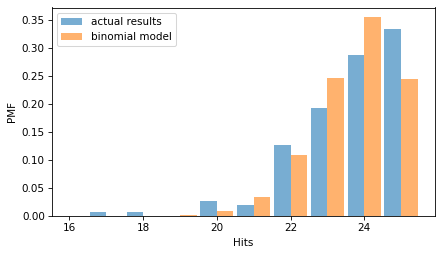

In [54]:
pmf_results = Pmf.from_seq(results, name="actual results")

two_bar_plots(pmf_results, pmf_binom)
decorate(xlabel="Hits", ylabel="PMF")

The binomial model is a good fit for the distribution of the data.

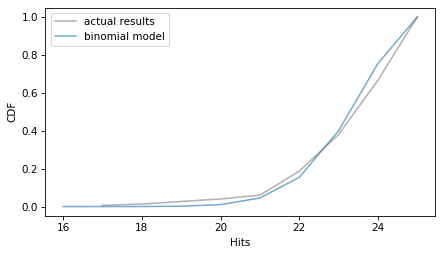

In [55]:
from thinkstats import two_cdf_plots

two_cdf_plots(pmf_results.make_cdf(), pmf_binom.make_cdf())
decorate(xlabel="Hits", ylabel="CDF")